# Testing the Iterative Ensemble Algorithms and Producing Metrics of Performance

In [169]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot  as plt
import numpy as np
import copy 
import os
os.environ["PROJ_LIB"] = "C:\\ProgramData\\Anaconda3\\Library\\share";
from mpl_toolkits.basemap import Basemap
from scipy import interpolate
from scipy import optimize
import random
import numpy as np
from scipy.interpolate import Akima1DInterpolator
from sklearn import datasets, linear_model
import pickle
import matplotlib

levels = [0, 1, 2, 3, 4, 5]
colors = ['black', 'green', 'brown', 'yellow', 'blue']
cmap, norm = matplotlib.colors.from_levels_and_colors(levels, colors)
    
plt.rcParams["font.family"] = "Times New Roman"


SMALL_SIZE = 8
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Individual algorithm simulations

In [170]:
# load test ensemble data
with open('test_data/2018_ensTest_48hrs.pickle', 'rb') as handle:
    ensemble_data = pickle.load(handle)
with open('test_data/2018_meanEnsTest_48hrs.pickle', 'rb') as handle:
    meanEnsTest_data = pickle.load(handle)
with open('test_data/2018_bestLabelTest_48hrs.pickle', 'rb') as handle:
    bestLabelTest_data = pickle.load(handle)

# initialization
ens_tn = ['AC00', 'AP01','AP02','AP03','AP04','AP05','AP06','AP07','AP08','AP09','AP10','AP11','AP12','AP13','AP14',
          'AP15','AP16','AP17','AP18','AP19','AP20']
ens_mean_tn = ['AEMN'] # ensemble mean track name
best_tn = ['BEST']

#forecast_periods = [0, 6, 12, 18, 24] # forecast horizon is 24hrs, and time step is 6 hrs, origin is from 6hrs
forecast_periods = [0, 6, 12, 18, 24, 30, 36, 42, 48] 

nens = len(ens_tn)
ntst = len(forecast_periods) # number of time steps. 6hrs is the time step for the GEFS forecasts.

# uniform sampling
#obs_times = min(forecast_periods) + np.linspace(0.5, max(forecast_periods), (max(forecast_periods) - min(forecast_periods))*5)

# Simulated satellite constellation timings
# 48 hours, 8 min interval
obs_times = np.array([0.806944444444445,1.01055555555556,1.21555555555556,1.42194444444444,1.63138888888889,1.84083333333333,2.05000000000000,2.26000000000000,2.47166666666667,2.68361111111111,2.89388888888889,3.10666666666667,3.32500000000000,3.54444444444444,3.77000000000000,8.59250000000000,8.78527777777778,8.99138888888889,9.20138888888889,9.40361111111111,9.60805555555556,9.82333333333333,10.0400000000000,10.2472222222222,10.4541666666667,10.6725000000000,10.8930555555556,11.1027777777778,11.3150000000000,11.5416666666667,12.5011111111111,12.6888888888889,12.8955555555556,13.1111111111111,13.3161111111111,13.5158333333333,13.7272222222222,13.9480555555556,14.1569444444444,14.3586111111111,14.5763888888889,14.8025000000000,15.0161111111111,15.2225000000000,15.4438888888889,15.6808333333333,16.4152777777778,16.6013888888889,16.8000000000000,17.0166666666667,17.2275000000000,17.4230555555556,17.5566666666667,17.6902777777778,17.8538888888889,18.0702777777778,18.2700000000000,18.4036111111111,18.5372222222222,18.7069444444444,18.9269444444444,19.1294444444444,19.3450000000000,19.5888888888889,20.3355555555556,20.5422222222222,20.7636111111111,20.9669444444444,21.1597222222222,21.3730555555556,21.5975000000000,21.8027777777778,21.9969444444444,22.2127777777778,22.4425000000000,22.6516666666667,22.8500000000000,23.0722222222222,23.3116666666667,24.2472222222222,24.4466666666667,24.6688888888889,24.8811111111111,25.0700000000000,25.2725000000000,25.5008333333333,25.7169444444444,25.9091666666667,26.1150000000000,26.3461111111111,26.5655555555556,26.7597222222222,26.9700000000000,27.2130555555556,32.0441666666667,32.2527777777778,32.4388888888889,32.6272222222222,32.8505555555556,33.0758333333333,33.2672222222222,33.4608333333333,33.6902777777778,33.9219444444444,34.1172222222222,34.3130555555556,34.5466666666667,34.7822222222222,34.9811111111111,35.1852777777778,36.1608333333333,36.3550000000000,36.5322222222222,36.7475000000000,36.9838888888889,37.1861111111111,37.3697222222222,37.5880555555556,37.8286111111111,38.0338888888889,38.2180555555556,38.4430555555556,38.6902777777778,38.9016666666667,39.0969444444444,39.9038888888889,40.0619444444444,40.2727777777778,40.4491666666667,40.6469444444444,40.7805555555556,40.9141666666667,41.1016666666667,41.2822222222222,41.4158333333333,41.5494444444445,41.7288888888889,41.9475000000000,42.1352777777778,42.3408333333333,42.4744444444444,42.6080555555556,42.8072222222222,43.0052777777778,43.8141666666667,44.0069444444444,44.1797222222222,44.3944444444444,44.6355555555556,44.8352777777778,45.0105555555556,45.2305555555556,45.4744444444444,45.6758333333333,45.8533333333333,46.0755555555556,46.3258333333333,46.5330555555556,46.7169444444444,47.7116666666667,47.9250000000000])

%run egctf_main.ipynb

In [177]:
ex = 60

senFPr = 50e3 # sensor footprint radius in [m]
obsErr = 100*707.106781186548**2 # [m^2] (variance from actul position) the observation error must be less than the senFRr! 

phase2_lastKnown_thresh = 48*60/60 # last time storm is seen in hours
timeSinceLastKnown = np.inf

regr_seg_gap_hrs = 60/60
regr_subseg_length_hrs = regr_seg_gap_hrs # ISSUE: Not sure of behaviour if these two are not equal

wetp = 1 # confidence in ensemble velocity 


ex_derr_aemn = []
ex_derr_algo = []

ex_num_seen_aemn = []
ex_num_seen_algo = []

ensTracks = ensemble_data[ex]
ensTracks = np.delete(ensTracks, 0, 1)
ensTracks = np.delete(ensTracks, 0, 1)
ensTracks = ensTracks.reshape(nens, ntst, 4)

bestTrack = bestLabelTest_data[ex]
bestTrack = np.delete(bestTrack, 0, 1)
bestTrack = np.delete(bestTrack, 0, 1)
bestTrack = bestTrack.reshape( ntst, 4)

aemnTrack = meanEnsTest_data[ex]
aemnTrack = np.delete(aemnTrack, 0, 1)
aemnTrack = np.delete(aemnTrack, 0, 1)
aemnTrack = aemnTrack.reshape(ntst, 4)

algo_results = algo(ensTracks, bestTrack, aemnTrack, obs_times, senFPr, obsErr, forecast_periods, nens,
                    phase2_lastKnown_thresh, regr_seg_gap_hrs, regr_subseg_length_hrs, wetp)
ex_derr_algo.append(algo_results['error_wna'])
ex_num_seen_algo.append(algo_results['num_succ_cap_wna'])

#with open('results/ex121_satCon.pickle', 'rb') as handle:
#    algo_results = pickle.load(handle)

average observation error with current algorithm [km] 4.8329432069412706
Successful storm captures  161.0
average observation error using aemn info [km] 125.24408903085559
Successful storm captures  30
Max observation error with current algorithm [km] 23.00244976755496


<IPython.core.display.Javascript object>


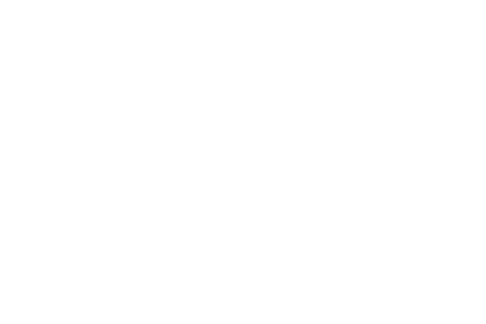

<IPython.core.display.Javascript object>


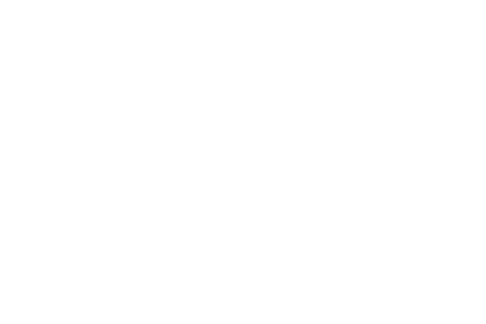

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [178]:
''' ALGO RESULTS '''
%matplotlib notebook
#calling it a second time may prevent some graphics errors
%matplotlib notebook  
import matplotlib.pyplot as plt

print('average observation error with current algorithm [km]',  algo_results['error_wna'])
print('Successful storm captures ', algo_results['num_succ_cap_wna'])
print('average observation error using aemn info [km]',  algo_results['error_waemn'])
print('Successful storm captures ', algo_results['num_succ_cap_waemn'])
print('Max observation error with current algorithm [km]',  np.max(algo_results['d_obs_bt'])*1e-3)

plt.figure()
plt.plot(obs_times, algo_results['d_aemn_bt'], 'mx')
plt.plot(obs_times, algo_results['d_obs_bt'], 'g.')

plt.figure()
# plot all the ensembles
for tn in range(0,nens):
    plt.plot(ensTracks[tn][:,2], ensTracks[tn][:,3], 'b--')
    
# plot the AEMN track
aemn_x = list(aemnTrack[:,2]) 
aemn_y = list(aemnTrack[:,3])
aemn_t = forecast_periods
aemn_fine_t = np.linspace(0,max(forecast_periods),1000)
aemn_fine_x, aemn_fine_y, aemn__fine_t = storm_position_akima(aemn_x, aemn_y, aemn_t, aemn_fine_t)
plt.plot(aemn_fine_x, aemn_fine_y, 'm')


# plot the best track
bt_x = list(bestTrack[:,2]) 
bt_y = list(bestTrack[:,3])
bt_t = forecast_periods
bt_fine_t = np.linspace(0,max(forecast_periods),1000)
bt_fine_x, bt_fine_y, bt_fine_t = storm_position_akima(bt_x, bt_y, bt_t, bt_fine_t)
plt.plot(bt_fine_x, bt_fine_y, 'k')

# plot the observed positions
plt.scatter(algo_results['obs_positions'][:,0], algo_results['obs_positions'][:,1], c = algo_results['seen'].flatten(), marker='s',cmap=cmap, norm=norm,)

# plot known positions
if(algo_results['known_storm_position'].size >0):
    plt.scatter(algo_results['known_storm_position'][:,0], algo_results['known_storm_position'][:,1], c = 'tab:grey', marker='s')

plt.xlabel('X')
plt.ylabel('Y')
plt.show();
print(algo_results['seen'].flatten(),)

with open('ex'+str(ex)+'_satCon.pickle', 'wb') as handle:
            pickle.dump(algo_results, handle, protocol=pickle.HIGHEST_PROTOCOL)  

<IPython.core.display.Javascript object>


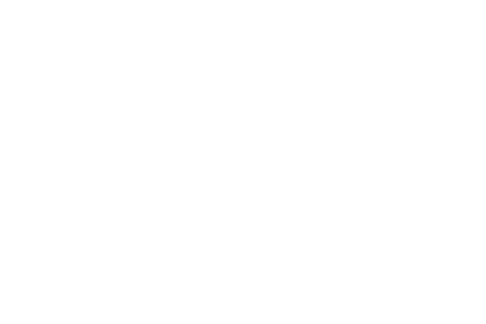

IndexError: too many indices for array

In [28]:
%matplotlib notebook
#calling it a second time may prevent some graphics errors
%matplotlib notebook 

import matplotlib.pyplot as plt

# produce the mean ensemble for an example forecast and see if it matches with the corresponding AEMN track 
ens_wts0 = np.ones((nens, 1))
ens_wts0 = ens_wts0/ np.sum(ens_wts0)
mean0_track = mean_ensemble(ensTracks, ens_wts0)

    
plt.figure()
# plot all the ensembles
for tn in range(0,nens):
    ens_x = list(ensTracks[tn][:,2]) 
    ens_y = list(ensTracks[tn][:,3])
    ens_t = forecast_periods
    ens_fine_t = np.linspace(0,max(forecast_periods),1000)
    ens_fine_x, ens_fine_y, ens__fine_t = storm_position_akima(ens_x, ens_y, ens_t, ens_fine_t)
    plt.plot(ens_fine_x*1e-3, ens_fine_y*1e-3, 'b--')
    
# plot the AEMN track
aemn_x = list(aemnTrack[:,2]) 
aemn_y = list(aemnTrack[:,3])
aemn_t = forecast_periods
aemn_fine_t = np.linspace(0,max(forecast_periods),1000)
aemn_fine_x, aemn_fine_y, aemn__fine_t = storm_position_akima(aemn_x, aemn_y, aemn_t, aemn_fine_t)
plt.plot(aemn_fine_x*1e-3, aemn_fine_y*1e-3, 'b')


# plot the best track
bt_x = list(bestTrack[:,2]) 
bt_y = list(bestTrack[:,3])
bt_t = forecast_periods
bt_fine_t = np.linspace(0,max(forecast_periods),1000)
bt_fine_x, bt_fine_y, bt_fine_t = storm_position_akima(bt_x, bt_y, bt_t, bt_fine_t)
plt.plot(bt_fine_x*1e-3, bt_fine_y*1e-3, 'k')

# plot the Calculated mean track
plt.plot(mean0_track[:,2]*1e-3, mean0_track[:,3]*1e-3, 'c')

# plot the observed positions
#seen = np.array(seen)
#plt.scatter(obs_positions[:,0]*1e-3, obs_positions[:,1]*1e-3, c = seen.flatten(), marker='s')


# known_storm_position
#if(algo_results['known_storm_position'].size >0):
    #plt.scatter(known_storm_position[:,0]*1e-3, known_storm_position[:,1]*1e-3, c = 'tab:orange', marker='s')


plt.xlabel('x [km]')
plt.ylabel('y [km]')
plt.show();
plt.gca().set_position([0, 0, 1, 1])
#plt.savefig("ensemble_illus.svg")

In [ ]:
%matplotlib notebook
#calling it a second time may prevent some graphics errors
%matplotlib notebook  

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook 


fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
ax = fig.gca(projection='3d')
# plot all the ensembles
for tn in range(0,nens):
    ax.plot(ensTracks[tn][:,2], ensTracks[tn][:,3], forecast_periods,'b--', alpha = 0.5)
    
# plot the AEMN track
aemn_x = list(aemnTrack[:,2]) 
aemn_y = list(aemnTrack[:,3])
aemn_t = forecast_periods
aemn_fine_t = np.linspace(0,max(forecast_periods),1000)
aemn_fine_x, aemn_fine_y, aemn__fine_t = storm_position_akima(aemn_x, aemn_y, aemn_t, aemn_fine_t)  
ax.plot(aemn_fine_x, aemn_fine_y, aemn_fine_t, 'm')

# plot the best track
bt_x = list(bestTrack[:,2]) 
bt_y = list(bestTrack[:,3])
bt_t = forecast_periods
bt_fine_t = np.linspace(0,max(forecast_periods),1000)
bt_fine_x, bt_fine_y, bt_fine_t = storm_position_akima(bt_x, bt_y, bt_t, bt_fine_t)
ax.plot(bt_fine_x, bt_fine_y, bt_fine_t, 'k')

# plot the observed positions
seen = np.array(algo_results['seen'].flatten())
ax.scatter(algo_results['obs_positions'][:,0], algo_results['obs_positions'][:,1], obs_times, c = seen.flatten(), marker='s')

# plot the known storm positions
if(algo_results['known_storm_position'].size >0):
    ax.scatter(algo_results['known_storm_position'][:,0].astype('float'), algo_results['known_storm_position'][:,1].astype('float'), algo_results['known_storm_position'][:,2].astype('float'), c = 'tab:orange', marker='^', facecolors='none', s=50)

plt.xlabel('X')
plt.ylabel('Y')
plt.show();

In [ ]:
algo_results['known_storm_position'][:,0].shape

In [ ]:
algo_results['known_storm_position'].size

In [ ]:
ensemble_data[ex][0]

### plots for paper

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


<IPython.core.display.Javascript object>


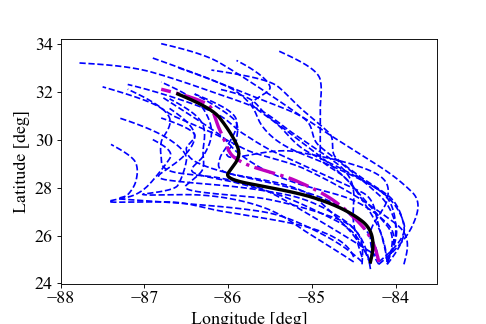

In [131]:
%matplotlib notebook
#calling it a second time may prevent some graphics errors
%matplotlib notebook  
import matplotlib.pyplot as plt

levels = [0, 1, 2, 3, 4, 5]
colors = ['olive', 'green', 'brown', 'yellow', 'blue']
cmap, norm = matplotlib.colors.from_levels_and_colors(levels, colors)
    
    
plt.rcParams["font.family"] = "Times New Roman"


SMALL_SIZE = 8
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

proj = Basemap(resolution='l',projection='eqdc',\
                lat_1=16.67,lat_2=33.33,lon_0=-45.0,
                llcrnrlon=-100 , llcrnrlat=0 , urcrnrlon=-10, urcrnrlat=50  )

# produce the mean ensemble for an example forecast and see if it matches with the corresponding AEMN track 
ens_wts0 = np.ones((nens, 1))
ens_wts0 = ens_wts0/ np.sum(ens_wts0)
mean0_track = mean_ensemble(ensTracks, ens_wts0)

    
plt.figure()

# plot all the ensembles

for tn in range(0,nens):
    ens_x = list(ensTracks[tn][:,2]) 
    ens_y = list(ensTracks[tn][:,3])
    ens_t = forecast_periods
    ens_fine_t = np.linspace(0,max(forecast_periods),1000)
    ens_fine_x, ens_fine_y, ens__fine_t = storm_position_akima(ens_x, ens_y, ens_t, ens_fine_t)
    lon, lat =  proj(ens_fine_x, ens_fine_y, inverse=True)
    plt.plot(lon, lat, 'b--')
    
# plot the AEMN track
aemn_x = list(aemnTrack[:,2]) 
aemn_y = list(aemnTrack[:,3])
aemn_t = forecast_periods
aemn_fine_t = np.linspace(0,max(forecast_periods),1000)
aemn_fine_x, aemn_fine_y, aemn__fine_t = storm_position_akima(aemn_x, aemn_y, aemn_t, aemn_fine_t)
lon, lat =  proj(aemn_fine_x, aemn_fine_y, inverse=True)
plt.plot(lon, lat, 'm', linewidth=3, linestyle='-.')


# plot the best track
bt_x = list(bestTrack[:,2]) 
bt_y = list(bestTrack[:,3])
bt_t = forecast_periods
bt_fine_t = np.linspace(0,max(forecast_periods),1000)
bt_fine_x, bt_fine_y, bt_fine_t = storm_position_akima(bt_x, bt_y, bt_t, bt_fine_t)
lon, lat =  proj(bt_fine_x, bt_fine_y, inverse=True)
plt.plot(lon, lat, 'k', linewidth=3)

plt.xlabel('Longitude [deg]')
plt.ylabel('Latitude [deg]')

#case 4
plt.xlim((-88, -83.5))
plt.ylim((24, 34.2))

#case 60
#plt.xlim((-50, -37.5))
#plt.ylim((18,22))

#case 121
#plt.xlim((-35, -20))
#plt.ylim((13,17.2))

#case 203
#plt.xlim((-65, -52.5))
#plt.ylim((11.8, 16.2))

#case 249
#plt.xlim((-58.5, -48))
#plt.ylim((36, 38.2))

plt.show();
#plt.gca().set_position([0, 0, 1, 1])
plt.savefig("ensembles.svg")

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


<IPython.core.display.Javascript object>


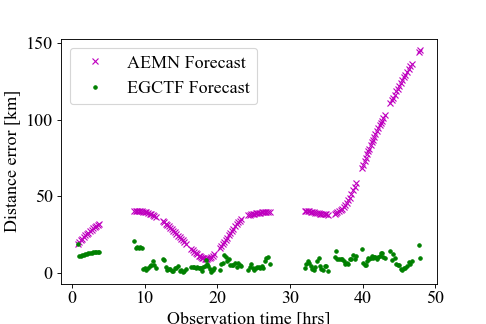

<IPython.core.display.Javascript object>


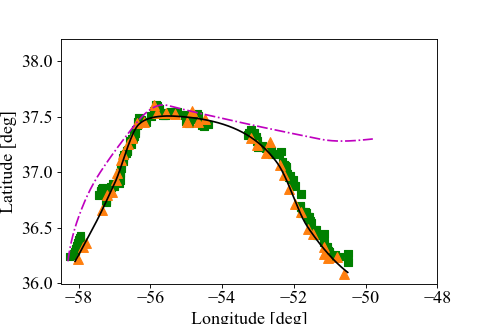

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [166]:
%matplotlib notebook
#calling it a second time may prevent some graphics errors
%matplotlib notebook  
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "Times New Roman"


SMALL_SIZE = 8
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

proj = Basemap(resolution='l',projection='eqdc',\
                lat_1=16.67,lat_2=33.33,lon_0=-45.0,
                llcrnrlon=-100 , llcrnrlat=0 , urcrnrlon=-10, urcrnrlat=50  )

plt.figure()

plt.plot(obs_times, algo_results['d_aemn_bt']*1e-3, 'mx')
plt.plot(obs_times, algo_results['d_obs_bt']*1e-3, 'g.')
plt.xlabel('Observation time [hrs]')
plt.ylabel('Distance error [km]')
plt.legend(['AEMN Forecast', 'EGCTF Forecast'])

plt.savefig("error.svg")
#plt.xlim((0,48))
#plt.ylim((0,80))


plt.figure()

# plot all the ensembles
#for tn in range(0,nens):
    #plt.plot(ensTracks[tn][:,2], ensTracks[tn][:,3], 'b--')
    
# plot the AEMN track
aemn_x = list(aemnTrack[:,2]) 
aemn_y = list(aemnTrack[:,3])
aemn_t = forecast_periods
aemn_fine_t = np.linspace(0,max(forecast_periods),1000)
aemn_fine_x, aemn_fine_y, aemn__fine_t = storm_position_akima(aemn_x, aemn_y, aemn_t, aemn_fine_t)
lon, lat =  proj(aemn_fine_x, aemn_fine_y, inverse=True)
plt.plot(lon, lat, 'm', linestyle='-.')

#for tn in range(0,nens):
#    ens_t = forecast_periods
#    ens_fine_t = np.linspace(0,max(forecast_periods),1000)
#    ens_fine_x, ens_fine_y, ens__fine_t = storm_position_akima(ensTracks[tn][:,2], ensTracks[tn][:,3], ens_t, ens_fine_t)
#    lon, lat =  proj(ens_fine_x, ens_fine_y, inverse=True)
#    plt.plot(lon, lat, 'b--', alpha = 0.5)

# plot the best track
bt_x = list(bestTrack[:,2]) 
bt_y = list(bestTrack[:,3])
bt_t = forecast_periods
bt_fine_t = np.linspace(0,max(forecast_periods),1000)
bt_fine_x, bt_fine_y, bt_fine_t = storm_position_akima(bt_x, bt_y, bt_t, bt_fine_t)
lon, lat =  proj(bt_fine_x, bt_fine_y, inverse=True)
plt.plot(lon, lat, 'k')

# plot the observed positions
lon, lat =  proj(algo_results['obs_positions'][:,0], algo_results['obs_positions'][:,1], inverse=True)
plt.scatter(lon, lat, c = algo_results['seen'].flatten(), marker='s', s=45, cmap=cmap, norm=norm)

# plot known positions
if(algo_results['known_storm_position'].size >0):
    lon, lat =  proj(algo_results['known_storm_position'][:,0], algo_results['known_storm_position'][:,1], inverse=True)
    plt.scatter(lon, lat , c = 'tab:orange', s=75, marker='^', facecolors='none', alpha = 1)

plt.xlabel('Longitude [deg]')
plt.ylabel('Latitude [deg]')

#case 4
#plt.xlim((-88, -83.5))
#plt.ylim((24, 34.2))

#case 60
#plt.xlim((-50, -37.5))
#plt.ylim((18,22))

#case 121
#plt.xlim((-35, -20))
#plt.ylim((13,17.2))

#case 203
#plt.xlim((-65, -52.5))
#plt.ylim((11.8, 16.2))

#case: 249
plt.xlim((-58.5, -48))
plt.ylim((36, 38.2))

#case: 77
#plt.xlim((-58.2, -51.8))
#plt.ylim((22.8, 25.8))

plt.show();
print(algo_results['seen'].flatten(),)
plt.savefig("algo_tracks.svg")

In [ ]:
%matplotlib notebook
#calling it a second time may prevent some graphics errors
%matplotlib notebook  
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams["font.family"] = "Times New Roman"

levels = [0, 1, 2, 3, 4, 5]
colors = ['olive', 'green', 'brown', 'yellow', 'blue']
cmap, norm = matplotlib.colors.from_levels_and_colors(levels, colors)


SMALL_SIZE = 8
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

proj = Basemap(resolution='l',projection='eqdc',\
                lat_1=16.67,lat_2=33.33,lon_0=-45.0,
                llcrnrlon=-100 , llcrnrlat=0 , urcrnrlon=-10, urcrnrlat=50 )


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# plot all the ensembles
for tn in range(0,nens):
    ens_t = forecast_periods
    ens_fine_t = np.linspace(0,max(forecast_periods),1000)
    ens_fine_x, ens_fine_y, ens__fine_t = storm_position_akima(ensTracks[tn][:,2], ensTracks[tn][:,3], ens_t, ens_fine_t)
    lon, lat =  proj(ens_fine_x, ens_fine_y, inverse=True)
    ax.plot(lon, lat, ens_fine_t,'b--')
    
# plot the AEMN track
aemn_x = list(aemnTrack[:,2]) 
aemn_y = list(aemnTrack[:,3])
aemn_t = forecast_periods
aemn_fine_t = np.linspace(0,max(forecast_periods),1000)
aemn_fine_x, aemn_fine_y, aemn__fine_t = storm_position_akima(aemn_x, aemn_y, aemn_t, aemn_fine_t)  
lon, lat =  proj(aemn_fine_x, aemn_fine_y, inverse=True)
ax.plot(lon, lat, aemn_fine_t, '-.m')

# plot the best track
bt_x = list(bestTrack[:,2]) 
bt_y = list(bestTrack[:,3])
bt_t = forecast_periods
bt_fine_t = np.linspace(0,max(forecast_periods),1000)
bt_fine_x, bt_fine_y, bt_fine_t = storm_position_akima(bt_x, bt_y, bt_t, bt_fine_t)
lon, lat =  proj(bt_fine_x, bt_fine_y, inverse=True)
ax.plot(lon, lat, bt_fine_t, 'k')

# plot the observed positions
lon, lat =  proj(algo_results['obs_positions'][:,0], algo_results['obs_positions'][:,1], inverse=True)
ax.scatter(lon, lat, obs_times, c = algo_results['seen'].flatten(), marker='s',cmap=cmap, norm=norm,)

# plot known positions
if(algo_results['known_storm_position'].size >0):
    lon, lat =  proj(algo_results['known_storm_position'][:,0], algo_results['known_storm_position'][:,1], inverse=True)
    ax.scatter(lon, lat , algo_results['known_storm_position'][:,2].astype(float), c = 'tab:orange', marker='^', facecolors='none', s=75)

plt.xlabel('Longitude [deg]')
plt.ylabel('Latitude [deg]')
plt.show();


In [ ]:
plt.savefig("allTracks_3d.svg")

In [ ]:
%matplotlib notebook
#calling it a second time may prevent some graphics errors
%matplotlib notebook  
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams["font.family"] = "Times New Roman"

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# plot the observed positions
lon, lat =  proj(algo_results['obs_positions'][:,0], algo_results['obs_positions'][:,1], inverse=True)
ax.scatter(lon, lat, obs_times, c = algo_results['seen'].flatten(), marker='s',cmap=cmap, norm=norm,)


plt.xlabel('Longitude [deg]')
plt.ylabel('Latitude [deg]')
plt.show();

### Skill versus forecast period 

58.847424051001795
74.4639091372034
87.02758965978202
90.7885571538751
92.45829808628947
93.84194834863126
95.29684698137737
96.14118059835094
0
0
25
49
64
80
108
131


<IPython.core.display.Javascript object>


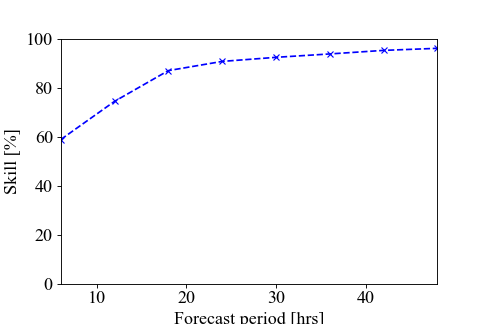

In [179]:
%matplotlib notebook
#calling it a second time may prevent some graphics errors
%matplotlib notebook  
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams["font.family"] = "Times New Roman"

levels = [0, 1, 2, 3, 4, 5]
colors = ['olive', 'green', 'brown', 'yellow', 'blue']
cmap, norm = matplotlib.colors.from_levels_and_colors(levels, colors)


SMALL_SIZE = 8
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


fp = [6,12,18,24,30,36,42,48]
s = []
additional_cap = []
for _fp in fp:
    x1 = sum(algo_results['d_aemn_bt'][0:len(obs_times[obs_times<=_fp])])[0]
    x2 = sum(algo_results['d_obs_bt'][0:len(obs_times[obs_times<=_fp])])[0]
    s.append(100.0 * (x1-x2)/x1)
    cap1 = sum(algo_results['d_aemn_bt'][0:len(obs_times[obs_times<=_fp])] < senFPr)[0]
    cap2 = sum(algo_results['d_obs_bt'][0:len(obs_times[obs_times<=_fp])] < senFPr)[0]
    additional_cap.append(cap2 - cap1)
    
print(*s,sep='\n')
print(*additional_cap,sep='\n')
fig = plt.figure()
plt.plot(fp, s,'bx--' )
plt.xlabel('Forecast period [hrs]')
plt.xlim((6,48))
plt.ylim((0,100))
plt.ylabel('Skill [%]')
plt.show();

In [ ]:
lon.shape

In [ ]:
lat.shape

In [ ]:
algo_results['known_storm_position'][:,2].shape

In [ ]:
algo_results['known_storm_position'][:,2]

### observation timing diagram

In [ ]:
%matplotlib notebook
#calling it a second time may prevent some graphics errors
%matplotlib notebook  
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams["font.family"] = "Times New Roman"

levels = [0, 1, 2, 3, 4, 5]
colors = ['olive', 'green', 'brown', 'yellow', 'blue']
cmap, norm = matplotlib.colors.from_levels_and_colors(levels, colors)


SMALL_SIZE = 8
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


plt.figure()

plt.plot(obs_times, np.ones(obs_times.shape),'g.')
plt.xlabel('Time [hrs]')
plt.ylabel('Observation [1/0]')

plt.xlim((0,50))
plt.ylim((0,5))


### plot successive ensembles

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  


<IPython.core.display.Javascript object>


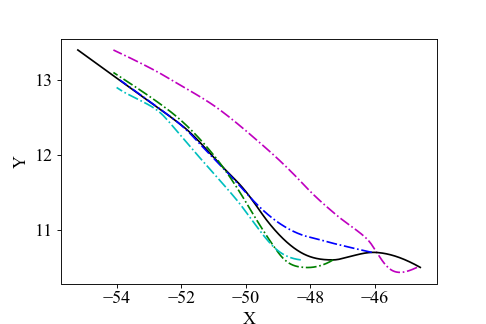

In [21]:
%matplotlib notebook
#calling it a second time may prevent some graphics errors
%matplotlib notebook  
import matplotlib.pyplot as plt

proj = Basemap(resolution='l',projection='eqdc',\
                lat_1=16.67,lat_2=33.33,lon_0=-45.0,
                llcrnrlon=-100 , llcrnrlat=0 , urcrnrlon=-10, urcrnrlat=50 )

ex = 14
ensTracks = ensemble_data[ex]
ensTracks = np.delete(ensTracks, 0, 1)
ensTracks = np.delete(ensTracks, 0, 1)
ensTracks = ensTracks.reshape(nens, ntst, 4)

bestTrack = bestLabelTest_data[ex]
bestTrack = np.delete(bestTrack, 0, 1)
bestTrack = np.delete(bestTrack, 0, 1)
bestTrack = bestTrack.reshape( ntst, 4)

aemnTrack = meanEnsTest_data[ex]
aemnTrack = np.delete(aemnTrack, 0, 1)
aemnTrack = np.delete(aemnTrack, 0, 1)
aemnTrack = aemnTrack.reshape(ntst, 4)

plt.figure()


# plot the AEMN track
aemn_x = list(aemnTrack[:,2]) 
aemn_y = list(aemnTrack[:,3])
aemn_t = forecast_periods
aemn_fine_t = np.linspace(0,max(forecast_periods),1000)
aemn_fine_x, aemn_fine_y, aemn__fine_t = storm_position_akima(aemn_x, aemn_y, aemn_t, aemn_fine_t)
lon, lat =  proj(aemn_fine_x, aemn_fine_y, inverse=True)
plt.plot(lon, lat, 'm', linestyle='-.')

# plot the best track
bt_x = list(bestTrack[:,2]) 
bt_y = list(bestTrack[:,3])
bt_t = forecast_periods
bt_fine_t = np.linspace(0,48,1000)
bt_fine_x, bt_fine_y, bt_fine_t = storm_position_akima(bt_x, bt_y, bt_t, bt_fine_t)
lon, lat =  proj(bt_fine_x, bt_fine_y, inverse=True)
plt.plot(lon, lat, 'k')

ex = 15
ensTracks = ensemble_data[ex]
ensTracks = np.delete(ensTracks, 0, 1)
ensTracks = np.delete(ensTracks, 0, 1)
ensTracks = ensTracks.reshape(nens, ntst, 4)

bestTrack = bestLabelTest_data[ex]
bestTrack = np.delete(bestTrack, 0, 1)
bestTrack = np.delete(bestTrack, 0, 1)
bestTrack = bestTrack.reshape( ntst, 4)

aemnTrack = meanEnsTest_data[ex]
aemnTrack = np.delete(aemnTrack, 0, 1)
aemnTrack = np.delete(aemnTrack, 0, 1)
aemnTrack = aemnTrack.reshape(ntst, 4)

# plot the AEMN track
aemn_x = list(aemnTrack[:,2]) 
aemn_y = list(aemnTrack[:,3])
aemn_t = forecast_periods
aemn_fine_t = np.linspace(0,42,1000)
aemn_fine_x, aemn_fine_y, aemn__fine_t = storm_position_akima(aemn_x, aemn_y, aemn_t, aemn_fine_t)
lon, lat =  proj(aemn_fine_x, aemn_fine_y, inverse=True)
plt.plot(lon, lat, 'b', linestyle='-.')




ex = 16
ensTracks = ensemble_data[ex]
ensTracks = np.delete(ensTracks, 0, 1)
ensTracks = np.delete(ensTracks, 0, 1)
ensTracks = ensTracks.reshape(nens, ntst, 4)

bestTrack = bestLabelTest_data[ex]
bestTrack = np.delete(bestTrack, 0, 1)
bestTrack = np.delete(bestTrack, 0, 1)
bestTrack = bestTrack.reshape( ntst, 4)

aemnTrack = meanEnsTest_data[ex]
aemnTrack = np.delete(aemnTrack, 0, 1)
aemnTrack = np.delete(aemnTrack, 0, 1)
aemnTrack = aemnTrack.reshape(ntst, 4)

# plot the AEMN track
aemn_x = list(aemnTrack[:,2]) 
aemn_y = list(aemnTrack[:,3])
aemn_t = forecast_periods
aemn_fine_t = np.linspace(0,36,1000)
aemn_fine_x, aemn_fine_y, aemn__fine_t = storm_position_akima(aemn_x, aemn_y, aemn_t, aemn_fine_t)
lon, lat =  proj(aemn_fine_x, aemn_fine_y, inverse=True)
plt.plot(lon, lat, 'g', linestyle='-.')



ex = 17
ensTracks = ensemble_data[ex]
ensTracks = np.delete(ensTracks, 0, 1)
ensTracks = np.delete(ensTracks, 0, 1)
ensTracks = ensTracks.reshape(nens, ntst, 4)

bestTrack = bestLabelTest_data[ex]
bestTrack = np.delete(bestTrack, 0, 1)
bestTrack = np.delete(bestTrack, 0, 1)
bestTrack = bestTrack.reshape( ntst, 4)

aemnTrack = meanEnsTest_data[ex]
aemnTrack = np.delete(aemnTrack, 0, 1)
aemnTrack = np.delete(aemnTrack, 0, 1)
aemnTrack = aemnTrack.reshape(ntst, 4)

# plot the AEMN track
aemn_x = list(aemnTrack[:,2]) 
aemn_y = list(aemnTrack[:,3])
aemn_t = forecast_periods
aemn_fine_t = np.linspace(0,30,1000)
aemn_fine_x, aemn_fine_y, aemn__fine_t = storm_position_akima(aemn_x, aemn_y, aemn_t, aemn_fine_t)
lon, lat =  proj(aemn_fine_x, aemn_fine_y, inverse=True)
plt.plot(lon, lat, 'c', linestyle='-.')




plt.xlabel('X')
plt.ylabel('Y')
plt.show();
